#Import dependencies

In [ ]:
!pip install transformers datasets trl peft accelerate bitsandbytes auto-gptq optimum

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, TrainingArguments
from trl import SFTTrainer

Mounted at /content/drive


# Set config

In [25]:
MODEL_ID = "TheBloke/zephyr-7B-alpha-GPTQ"
DATASET = "/content/drive/MyDrive/Climate Change AIctivist/combined_questions_answers.json"
CONTEXT_FIELD= ""
INSTRUCTION_FIELD = "instruction"
TARGET_FIELD = "response"
BITS = 4
DISABLE_EXLLAMA = True
DEVICE_MAP = "auto"
USE_CACHE = False
LORA_R = 16
LORA_ALPHA = 16
LORA_DROPOUT = 0.05
BIAS = "none"
TARGET_MODULES = ["q_proj", "v_proj"]
TASK_TYPE = "CAUSAL_LM"
OUTPUT_DIR = "zephyr-climate-change-assistant"
BATCH_SIZE = 8
GRAD_ACCUMULATION_STEPS = 1
OPTIMIZER = "paged_adamw_32bit"
LR = 2e-4
LR_SCHEDULER = "cosine"
LOGGING_STEPS = 50
SAVE_STRATEGY = "epoch"
NUM_TRAIN_EPOCHS = 3
MAX_STEPS = 3000
FP16 = True
PUSH_TO_HUB = True
DATASET_TEXT_FIELD = "text"
MAX_SEQ_LENGTH = 1024
PACKING = False

# Import data

In [5]:
data = load_dataset("json", data_files = DATASET)
df = data["train"].to_pandas()
df

Generating train split: 0 examples [00:00, ? examples/s]

,question,answer
0,Define Abundance?,The number of individuals or related measure o...
1,Define Acidification?,Change in natural chemical balance caused by a...
2,Define Adaptation?,Adjustment in natural or human systems to a ne...
3,Define Adaptive capacity?,The ability of a system to adjust to climate c...
4,Define Aerosol?,A collection of airborne solid or liquid parti...
...,...,...
27503,What is a major concern regarding research on ...,The lack of research is a major concern.
27504,Where has the majority of relevant research in...,The majority of relevant research has been con...
27505,"How do factors such as sources, disposal, and ...","Factors such as sources, disposal, and fate of..."
27506,What does the knowledge gap in research on eme...,The knowledge gap highlights the need for regi...


In [6]:
df = data["train"].to_pandas()
df['formatted'] = "Q: " + df['question'] + "\nA: " + df['answer']
df

,question,answer,formatted
0,Define Abundance?,The number of individuals or related measure o...,Q: Define Abundance?\nA: The number of individ...
1,Define Acidification?,Change in natural chemical balance caused by a...,Q: Define Acidification?\nA: Change in natural...
2,Define Adaptation?,Adjustment in natural or human systems to a ne...,Q: Define Adaptation?\nA: Adjustment in natura...
3,Define Adaptive capacity?,The ability of a system to adjust to climate c...,Q: Define Adaptive capacity?\nA: The ability o...
4,Define Aerosol?,A collection of airborne solid or liquid parti...,Q: Define Aerosol?\nA: A collection of airborn...
...,...,...,...
27503,What is a major concern regarding research on ...,The lack of research is a major concern.,Q: What is a major concern regarding research ...
27504,Where has the majority of relevant research in...,The majority of relevant research has been con...,Q: Where has the majority of relevant research...
27505,"How do factors such as sources, disposal, and ...","Factors such as sources, disposal, and fate of...","Q: How do factors such as sources, disposal, a..."
27506,What does the knowledge gap in research on eme...,The knowledge gap highlights the need for regi...,Q: What does the knowledge gap in research on ...


In [8]:
def process_data(example):

        '''
        Helper function to process the dataset sample by adding prompt and clean if necessary.

        Args:
        example: Data sample

        Returns:
        processed_example: Data sample post processing
        '''

        processed_example = "<|system|>\n You are a chatbot that provides educational climate change content.\n<|user|>\n" + example["question"] + "\n<|assistant|>\n" + example["answer"]

        return processed_example

In [16]:
df["text"] = process_data(df)

In [17]:
print(df.iloc[0].text)

<|system|>
 You are a chatbot that provides educational climate change content.
<|user|>
Define Abundance?
<|assistant|>
The number of individuals or related measure of quantity (such as biomass) in a population, community or spatial unit.


In [18]:
processed_data = Dataset.from_pandas(df[["text"]])
processed_data

Dataset({
    features: ['text'],
    num_rows: 27508
})

#Download model, config LoRA

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("TheBloke/zephyr-7B-alpha-GPTQ")
tokenizer.pad_token = tokenizer.eos_token

In [26]:
bnb_config = GPTQConfig(bits=4,
                        disable_exllama=True,
                        device_map="auto",
                        use_cache=False,
                        lora_r=16,
                        lora_alpha=16,
                        tokenizer=tokenizer
                                )
#
model = AutoModelForCausalLM.from_pretrained("TheBloke/zephyr-7B-alpha-GPTQ",
                                              quantization_config=bnb_config,
                                              device_map="auto",
                                              use_cache=False,
                                              )

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.
You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute and has already quantized weights. However, loading attributes (e.g. use_exllama, exllama_config, use_cuda_fp16, max_input_length) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.


In [27]:
model.config.use_cache=False
model.config.pretraining_tp=1
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
                            r=LORA_R,
                            lora_alpha=LORA_ALPHA,
                            lora_dropout=LORA_DROPOUT,
                            bias=BIAS,
                            task_type=TASK_TYPE,
                            target_modules=TARGET_MODULES
                        )

model = get_peft_model(model, peft_config)

#Train

In [28]:
training_arguments = TrainingArguments(output_dir=OUTPUT_DIR,
                                      per_device_train_batch_size=BATCH_SIZE,
                                      gradient_accumulation_steps=GRAD_ACCUMULATION_STEPS,
                                      optim=OPTIMIZER,
                                      learning_rate=LR,
                                      lr_scheduler_type=LR_SCHEDULER,
                                      save_strategy=SAVE_STRATEGY,
                                      logging_steps=LOGGING_STEPS,
                                      num_train_epochs=NUM_TRAIN_EPOCHS,
                                      max_steps=MAX_STEPS,
                                      fp16=FP16,
                                      push_to_hub=PUSH_TO_HUB)

In [29]:
trainer = SFTTrainer(model=model,
                      train_dataset=processed_data,
                      peft_config=peft_config,
                      dataset_text_field=DATASET_TEXT_FIELD,
                      args=training_arguments,
                      tokenizer=tokenizer,
                      packing=PACKING,
                      max_seq_length=MAX_SEQ_LENGTH
                    )
trainer.train()
trainer.push_to_hub()



			PREPARED FOR FINETUNING




Map:   0%|          | 0/27508 [00:00<?, ? examples/s]

Step,Training Loss
50,1.197400
100,0.945300
150,0.917200
200,0.903700
250,0.879800
300,0.906700
350,0.910600
400,0.916600
450,0.886300
500,0.904300


Step,Training Loss
50,1.197400
100,0.945300
150,0.917200
200,0.903700
250,0.879800
300,0.906700
350,0.910600
400,0.916600
450,0.886300
500,0.904300




			FINETUNING COMPLETED




CommitInfo(commit_url='https://huggingface.co/izh97/zephyr-climate-change-assistant/commit/c5aefd925f368f652de9f1d29d13e2ccc60c2231', commit_message='End of training', commit_description='', oid='c5aefd925f368f652de9f1d29d13e2ccc60c2231', pr_url=None, pr_revision=None, pr_num=None)

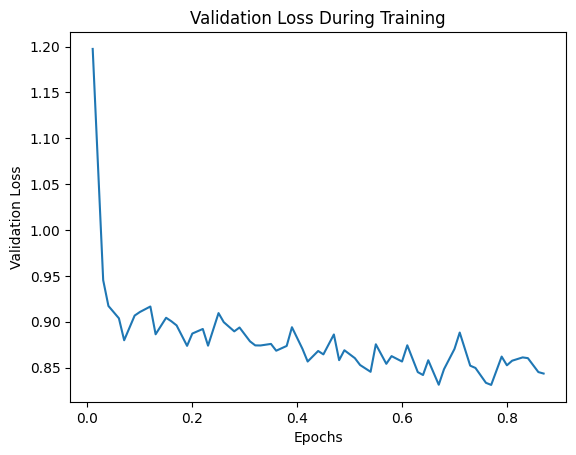

Log history saved to /content/drive/MyDrive/Climate Change AIctivist/log_history.json


In [30]:
import matplotlib.pyplot as plt
log_history = trainer.state.log_history
# Filtering out entries that have the 'loss' key
loss_data = [entry for entry in log_history if 'loss' in entry]

# Extracting loss and epoch values
losses = [entry['loss'] for entry in loss_data]
epochs = [entry['epoch'] for entry in loss_data]

# Plotting
plt.plot(epochs, losses)
plt.title('Validation Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

import json

# File path where you want to save the file
file_path = '/content/drive/MyDrive/Climate Change AIctivist/log_history.json'

# Writing the data to a file in JSON format
with open(file_path, 'w') as file:
    json.dump(log_history, file, indent=4)

print(f"Log history saved to {file_path}")
